# Model Estimations

In `Orbit`, we introduce three methods to estimate model parameters (a.k.a posteriors in Bayesian).

1. Maximum a Posteriori (MAP)
2. full Bayesian estimation
3. aggregated posteriors

In [1]:
from orbit.utils.dataset import load_iclaims
from orbit.models.ets import ETSMAP, ETSFull, ETSAggregated
from orbit.diagnostics.plot import plot_predicted_data

### Train / Test Split

In [2]:
# load data
df = load_iclaims()
test_size = 52
train_df = df[:-test_size]
test_df = df[-test_size:]
response_col = 'claims'
date_col = 'week'

## Maximum a Posteriori (MAP)

In general, we use the naming convenience of `TheModelMAP` to represent a model using MAP estimation.  For example, you will find  `ETSMAP`, and in later sections, `DLTMAP` and `LGTMAP`.  The advantage of such method is fast computation time.  Meanwhile, we don't report prediction range in current version.  In dev version, the inference is generated by the noise process.

In [3]:
%%time
ets = ETSMAP(
    response_col=response_col,
    date_col=date_col,
    seasonality=52,
    seed=8888,
)
ets.fit(df=train_df)
predicted_df = ets.predict(df=test_df)

CPU times: user 31.1 ms, sys: 10.5 ms, total: 41.6 ms
Wall time: 118 ms


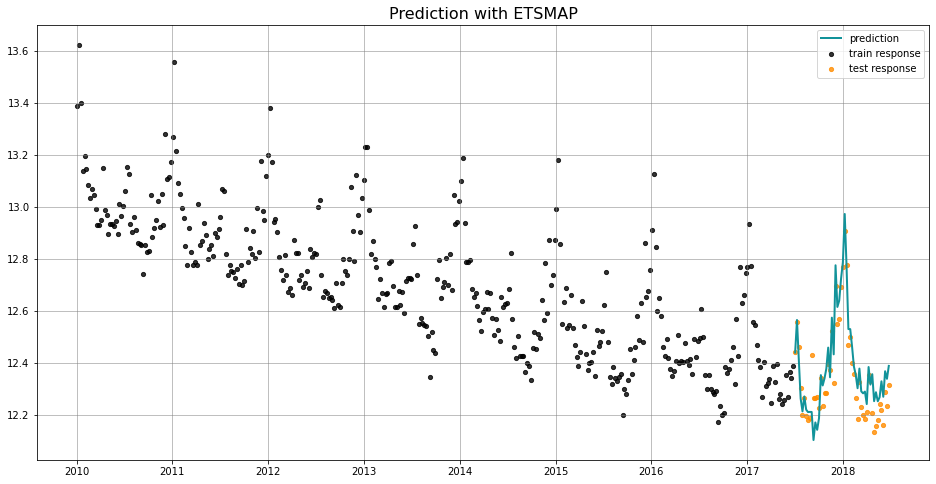

In [4]:
_ = plot_predicted_data(training_actual_df=train_df, predicted_df=predicted_df, 
                    date_col=date_col, actual_col=response_col,  
                    test_actual_df=test_df, title='Prediction with ETSMAP')

## Full Bayesian Estimation

We use the naming convenience of `TheModelFull` to represent a model using full Bayesian estimation.  This usually takes longer time to fit the model by using No-U-Turn Sampler [(Hoffman and Gelman 2011)](https://arxiv.org/abs/1111.4246).  The inference and estimation are usually more robust.  You'll other full Bayesian model such as  `DLTFull` and `LGTFull` in later section.

In [5]:
%%time
ets = ETSFull(
    response_col=response_col,
    date_col=date_col,
    seasonality=52,
    seed=8888,
    num_warmup=400,
    num_sample=400,
)
ets.fit(df=train_df)
predicted_df = ets.predict(df=test_df)

CPU times: user 495 ms, sys: 71.4 ms, total: 567 ms
Wall time: 1.6 s


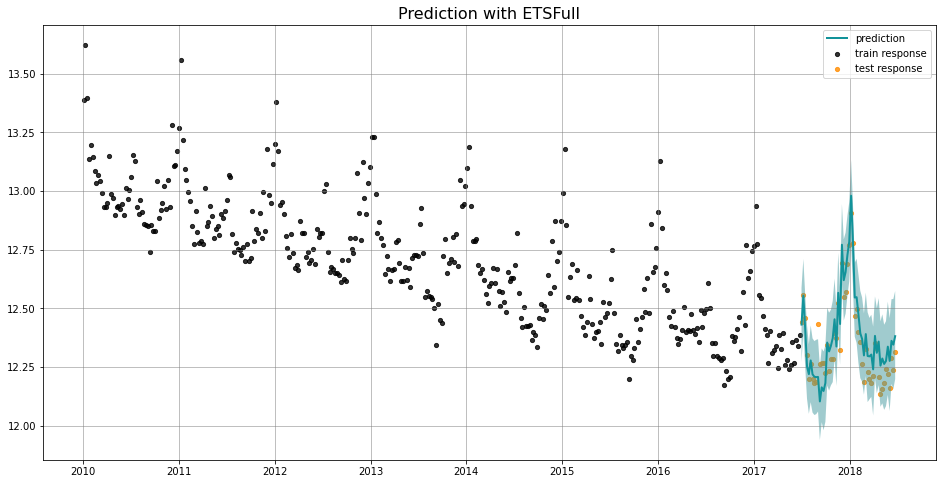

In [6]:
_ = plot_predicted_data(training_actual_df=train_df, predicted_df=predicted_df, 
                    date_col=date_col, actual_col=response_col,  
                    test_actual_df=test_df, title='Prediction with ETSFull')

You can also access the posterior samples by the attribute of `._posterior_samples` as a `dict`.

In [7]:
ets._posterior_samples.keys()

odict_keys(['l', 'lev_sm', 'obs_sigma', 's', 'sea_sm', 'lp__'])

## Aggregated Posteriors

We use the naming convenience of `TheModelAggregated` to represent a model using aggregate posteriors.  Just like full Bayesian method, it runs through MCMC algorithm such as NUTS.  The difference from a full model is that aggregated model will call an aggregated method such as `mean` or `median` to aggregate posterior samples as point estimates.  Then the prediction will be similar point forecast method to `MAP`.

You'll find other aggregated models such as `DLTAggregated` and `LGTAggregated`  in later section.

In [8]:
%%time
ets = ETSAggregated(
    response_col=response_col,
    date_col=date_col,
    seasonality=52,
    seed=8888,
)
ets.fit(df=train_df)
predicted_df = ets.predict(df=test_df)

CPU times: user 314 ms, sys: 85.8 ms, total: 400 ms
Wall time: 1.72 s


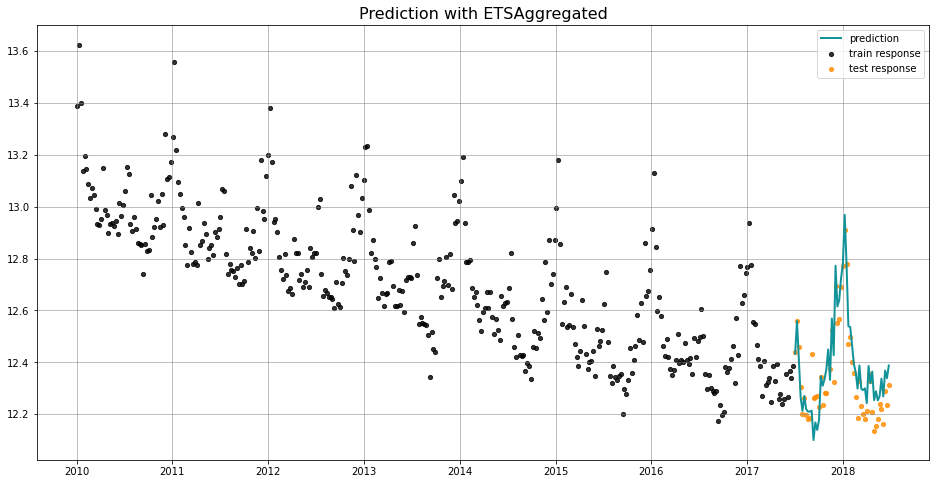

In [9]:
_ = plot_predicted_data(training_actual_df=train_df, predicted_df=predicted_df, 
                    date_col=date_col, actual_col=response_col,  
                    test_actual_df=test_df, title='Prediction with ETSAggregated')